In [69]:
import tensorflow as tf
import keras
from keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, SeparableConv2D, Conv2DTranspose
from keras.layers import Concatenate, Dense, Flatten, Reshape
from keras.models import Model, load_model
from PIL import Image
import pandas as pd
import numpy as np
import math
import PIL.ImageOps
import random
import matplotlib.pyplot as plt

In [5]:
def wvnet(anc=16, image_dimensions = (256, 256), encoding_length=1024):
    im_dim = image_dimensions
    k=1

    inputs = Input(shape=(im_dim[0], im_dim[1], 1))
    conv3x3_1 = Conv2D(kernel_size=(3,3), filters=anc*1, padding='same', activation='relu')(inputs)
    batchnorm1 = BatchNormalization()(conv3x3_1)
    conv3x3_2 = Conv2D(kernel_size=(3,3), filters=anc*1, padding='same', activation='relu')(batchnorm1)
    batchnorm2 = BatchNormalization()(conv3x3_2)

    maxp1 = MaxPooling2D((2,2))(batchnorm2)
    sepconv1 = SeparableConv2D(kernel_size=(3,3), filters=anc*2, padding='same', activation='relu')(maxp1)
    sepconv2 = SeparableConv2D(kernel_size=(3,3), filters=anc*2, padding='same', activation='relu')(sepconv1)

    maxp2 = MaxPooling2D((2,2))(sepconv2)
    sepconv3 = SeparableConv2D(kernel_size=(3,3), filters=anc*4, padding='same', activation='relu')(maxp2)
    sepconv4 = SeparableConv2D(kernel_size=(3,3), filters=anc*4, padding='same', activation='relu')(sepconv3)

    maxp3 = MaxPooling2D((2,2))(sepconv4)
    sepconv5 = SeparableConv2D(kernel_size=(3,3), filters=anc*8, padding='same', activation='relu')(maxp3)
    sepconv6 = SeparableConv2D(kernel_size=(3,3), filters=anc*8, padding='same', activation='relu')(sepconv5)

    maxp4 = MaxPooling2D((2,2))(sepconv6)
    sepconv7 = SeparableConv2D(kernel_size=(3,3), filters=anc*16, padding='same', activation='relu')(maxp4)
    sepconv8 = SeparableConv2D(kernel_size=(3,3), filters=anc*16, padding='same', activation='relu')(sepconv7)

    #take down tensor for encoding.
    maxp_out1 = MaxPooling2D((2,2))(sepconv8)

    #this layer does the encoding
    encoder_convolution = Conv2D(kernel_size=(8, 8), filters=encoding_length, activation='relu', name='encoder_convolution')(maxp_out1)
    #this is our encoding:
    flattened_encoding = Flatten()(encoder_convolution)

    up1 = Conv2DTranspose(kernel_size=(2,2), strides=2, filters=anc*8)(sepconv8)
    concat1 = Concatenate()([sepconv6, up1])
    sepconv9 = SeparableConv2D(kernel_size=(3,3), filters=anc*8, padding='same', activation='relu')(concat1)
    sepconv10 = SeparableConv2D(kernel_size=(3,3), filters=anc*8, padding='same', activation='relu')(sepconv9)

    up2 = Conv2DTranspose(kernel_size=(2,2), strides=2, filters=anc*4)(sepconv10)
    concat2 = Concatenate()([sepconv4, up2])
    sepconv11 = SeparableConv2D(kernel_size=(3,3), filters=anc*4, padding='same', activation='relu')(concat2)
    sepconv12 = SeparableConv2D(kernel_size=(3,3), filters=anc*4, padding='same', activation='relu')(sepconv11)

    up3 = Conv2DTranspose(kernel_size=(2,2), strides=2, filters=anc*2)(sepconv12)
    concat3 = Concatenate()([sepconv2, up3])
    sepconv13 = SeparableConv2D(kernel_size=(3,3), filters=anc*2, padding='same', activation='relu')(concat3)
    sepconv14 = SeparableConv2D(kernel_size=(3,3), filters=anc*2, padding='same', activation='relu')(sepconv13)

    up4 = Conv2DTranspose(kernel_size=(2,2), strides=2, filters=anc*1)(sepconv14)
    concat4 = Concatenate()([batchnorm2, up4])
    sepconv15 = SeparableConv2D(kernel_size=(3,3), filters=anc*1, padding='same', activation='relu')(concat4)
    sepconv16 = SeparableConv2D(kernel_size=(3,3), filters=anc*1, padding='same', activation='relu')(sepconv15)

    pixel_map = Conv2D(kernel_size=(1,1), filters=k, activation='sigmoid', name='pixel_map')(sepconv16)

    #This part of the model generates the image reconstruction outputs.
    conv3x3_1b = Conv2D(kernel_size=(3,3), filters=anc*1, padding='same', activation='relu')(pixel_map)
    batchnorm1b = BatchNormalization()(conv3x3_1b)
    conv3x3_2b = Conv2D(kernel_size=(3,3), filters=anc*1, padding='same', activation='relu')(batchnorm1b)
    batchnorm2b = BatchNormalization()(conv3x3_2b)

    maxp1b = MaxPooling2D((2,2))(batchnorm2b)
    sepconv1b = SeparableConv2D(kernel_size=(3,3), filters=anc*2, padding='same', activation='relu')(maxp1b)
    sepconv2b = SeparableConv2D(kernel_size=(3,3), filters=anc*2, padding='same', activation='relu')(sepconv1b)

    maxp2b = MaxPooling2D((2,2))(sepconv2b)
    sepconv3b = SeparableConv2D(kernel_size=(3,3), filters=anc*4, padding='same', activation='relu')(maxp2b)
    sepconv4b = SeparableConv2D(kernel_size=(3,3), filters=anc*4, padding='same', activation='relu')(sepconv3b)

    maxp3b = MaxPooling2D((2,2))(sepconv4b)
    sepconv5b = SeparableConv2D(kernel_size=(3,3), filters=anc*8, padding='same', activation='relu')(maxp3b)
    sepconv6b = SeparableConv2D(kernel_size=(3,3), filters=anc*8, padding='same', activation='relu')(sepconv5b)

    maxp4b = MaxPooling2D((2,2))(sepconv6b)
    sepconv7b = SeparableConv2D(kernel_size=(3,3), filters=anc*16, padding='same', activation='relu')(maxp4b)
    sepconv8b = SeparableConv2D(kernel_size=(3,3), filters=anc*16, padding='same', activation='relu')(sepconv7b)

    #We recover the information taken at maxp_out1
    maxp_out2 = MaxPooling2D((2,2))(sepconv8b)

    #now reshape and transpose convolution to reconstruct input image
    reshaped = Reshape(target_shape=(1, 1, encoding_length))(flattened_encoding)
    decoder_convolution1 = Conv2DTranspose(kernel_size=(8,8), strides=1, filters=anc*16)(reshaped)
    decoder_concat1 = Concatenate()([decoder_convolution1, maxp_out2])
    decoder_convolution1x1_1 = Conv2D(kernel_size=(1,1), strides=1, filters=anc*16, activation='relu')(decoder_concat1)
    decoder_convolution2 = Conv2DTranspose(kernel_size=(2,2), strides=2, filters=anc*8)(decoder_convolution1x1_1)
    decoder_concat2 = Concatenate()([decoder_convolution2, sepconv8b])
    decoder_convolution1x1_2 = Conv2D(kernel_size=(1,1), strides=1, filters=anc*16, activation='relu')(decoder_concat2)

    #and complete the w for reconstructed image
    up1b = Conv2DTranspose(kernel_size=(2,2), strides=2, filters=anc*8)(decoder_convolution1x1_2)
    concat1b = Concatenate()([sepconv6b, up1b])
    sepconv9b = SeparableConv2D(kernel_size=(3,3), filters=anc*8, padding='same', activation='relu')(concat1b)
    sepconv10b = SeparableConv2D(kernel_size=(3,3), filters=anc*8, padding='same', activation='relu')(sepconv9b)

    up2b = Conv2DTranspose(kernel_size=(2,2), strides=2, filters=anc*4)(sepconv10b)
    concat2b = Concatenate()([sepconv4b, up2b])
    sepconv11b = SeparableConv2D(kernel_size=(3,3), filters=anc*4, padding='same', activation='relu')(concat2b)
    sepconv12b = SeparableConv2D(kernel_size=(3,3), filters=anc*4, padding='same', activation='relu')(sepconv11b)

    up3b = Conv2DTranspose(kernel_size=(2,2), strides=2, filters=anc*2)(sepconv12b)
    concat3b = Concatenate()([sepconv2b, up3b])
    sepconv13b = SeparableConv2D(kernel_size=(3,3), filters=anc*2, padding='same', activation='relu')(concat3b)
    sepconv14b = SeparableConv2D(kernel_size=(3,3), filters=anc*2, padding='same', activation='relu')(sepconv13b)

    up4b = Conv2DTranspose(kernel_size=(2,2), strides=2, filters=anc*1)(sepconv14b)
    concat4b = Concatenate()([batchnorm2b, up4b])
    sepconv15b = SeparableConv2D(kernel_size=(3,3), filters=anc*1, padding='same', activation='relu')(concat4b)
    sepconv16b = SeparableConv2D(kernel_size=(3,3), filters=anc*1, padding='same', activation='relu')(sepconv15b)

    reconstructed_image = Conv2D(kernel_size=(1,1), filters=1, name='reconstruction')(sepconv16b)



    #And construct
    model = Model(inputs=inputs, outputs=[pixel_map, reconstructed_image])
    return model

model = wvnet(anc=64, encoding_length=1024)
model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 256, 256, 64) 640         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_13 (BatchNo (None, 256, 256, 64) 256         conv2d_17[0][0]                  
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 256, 256, 64) 36928       batch_normalization_13[0][0]     
__________________________________________________________________________________________________
batch_norm

In [85]:
path_to_target = './mask/{}_mask.bmp'
path_to_image = './raw/tile{}.pgm'

def load_target(tile, path_to_target=path_to_target):
    image = Image.open(path_to_target.format(tile))
    return image

def load_image(tile, path_to_image=path_to_image):
    image = Image.open(path_to_image.format(tile))
    return image

def rotated_crop(w, h, angle):
    """
    Given a rectangle of size wxh that has been rotated by 'angle' (in
    radians), computes the width and height of the largest possible
    axis-aligned rectangle (maximal area) within the rotated rectangle.
    """
    if w <= 0 or h <= 0:
        return 0,0

    width_is_longer = w >= h
    side_long, side_short = (w,h) if width_is_longer else (h,w)

    # since the solutions for angle, -angle and 180-angle are all the same,
    # if suffices to look at the first quadrant and the absolute values of sin,cos:
    sin_a, cos_a = abs(math.sin(angle)), abs(math.cos(angle))
    if side_short <= 2.*sin_a*cos_a*side_long or abs(sin_a-cos_a) < 1e-10:
        # half constrained case: two crop corners touch the longer side,
        #   the other two corners are on the mid-line parallel to the longer line
        x = 0.5*side_short
        wr,hr = (x/sin_a,x/cos_a) if width_is_longer else (x/cos_a,x/sin_a)
    else:
        # fully constrained case: crop touches all 4 sides
        cos_2a = cos_a*cos_a - sin_a*sin_a
        wr,hr = (w*cos_a - h*sin_a)/cos_2a, (h*cos_a - w*sin_a)/cos_2a

    return wr,hr

def rotate(img, angle):
    """Rotates and crops image to remove any black areas.
    Works between 0-90 degrees. Input is a PIL image, and
    an angle in degrees."""
    rads = math.radians(angle)
    w = img.size[0]
    h = img.size[1]
    wr, hr = rotated_crop(w, h, rads)
    wr, hr = int(wr), int(hr)
    h_bb = w*math.sin(rads) + h*math.cos(rads)
    w_bb = w*math.cos(rads) + h*math.sin(rads)
    new_x = (w_bb-wr)/2
    new_y = (h_bb-hr)/2
    crop_coords = (new_x, new_y, new_x+wr, new_y+hr)
    rotated = img.rotate(angle, expand=True)
    cropped = rotated.crop(crop_coords)
    return cropped

def force_smooth(img):
    if type(img) != type(np.array([0])):
        in_img = np.array(img)
    else:
        in_img = img
    img_shape = in_img.shape
    flat_img = in_img.flatten()
    dist_length = len(flat_img)
    as_series = pd.Series(flat_img)
    idx_order = as_series.sort_values(ascending=True).index
    distribution = np.array([x for x in range(dist_length)])
    distribution = distribution/dist_length
    ordered_dist = pd.Series(distribution).sort_values().values
    new_series = pd.Series(ordered_dist)
    new_series.index = idx_order
    result = new_series.sort_index().values.reshape(img_shape)
    return result

def augment(image, target, rotation=True):
    if rotation:
        rot = random.random()*90
        image = rotate(image, rot)
        target = rotate(target, rot)
    mirrorx = random.choice([True, False])
    if mirrorx:
        image = PIL.ImageOps.mirror(image)
        target = PIL.ImageOps.mirror(target)
    mirrory = random.choice([True, False])
    if mirrory:
        image = PIL.ImageOps.flip(image)
        target = PIL.ImageOps.flip(target)
    return image, target

def crop_pair(image, target, loc=(0, 0), dims=(256, 256)):
    x0 = loc[0]
    y0 = loc[1]
    x1 = loc[0]+dims[0]
    y1 = loc[1]+dims[1]
    image = image.crop((x0, y0, x1, y1))
    target = target.crop((x0, y0, x1, y1))
    return image, target

def select_coordinates(img, crop_dims=(256, 256)):
    img_dims = (img.size[0], img.size[1])
    min_x = 0
    min_y = 0
    max_x = img_dims[0] - crop_dims[0]
    max_y = img_dims[1] - crop_dims[0]
    x = random.randint(min_x, max_x)
    y = random.randint(min_y, max_y)
    return x, y

def to_tensor(image, target, choose=True, coords=None, crop_dims=(256, 256)):
    if choose:
        coords = select_coordinates(image, crop_dims=crop_dims)
    image, target = crop_pair(image, target, loc=coords, dims=crop_dims)
    image = force_smooth(image)
    image = np.expand_dims(image, axis=-1)
    target = np.array(target)/255
    target = np.expand_dims(target, axis=-1)
    return image, target
    
train_tile_names = ['1_24', '2_24', '3_24', '3_25', '1_25']
train_tiles = [(load_image(tile), load_target(tile)) for tile in train_tile_names]
val_tile_names = ['2_25']
val_tiles = [(load_image(tile), load_target(tile)) for tile in val_tile_names]

def make_batch(tiles=train_tiles, batch_size=10, crop_dims=(256, 256)):
    batch_in = []
    batch_out = []
    while len(batch_in) < batch_size:
        img_target = random.choice(tiles)
        image = img_target[0]
        target = img_target[1]
        image, target = augment(image, target)
        image, target = to_tensor(image, target)
        batch_in.append(image)
        batch_out.append(target)
    X = np.array(batch_in)
    Y = np.array(batch_out)
    return X, [Y, X]

def train_batch_gen(batch_size=10):
    while True:
        yield make_batch(batch_size=batch_size)
    
def val_batch_gen(tiles=val_tiles, batch_size=12):
    """use three validation steps."""
    batch_in = []
    batch_out = []
    count = 0
    while True:
        for img_target in tiles:
            xs = [i*256 for i in range(6)]
            ys = [i*256 for i in range(6)]
            for x in xs:
                for y in ys:
                    count+=1
                    if len(batch_in) == batch_size:
                        X = np.array(batch_in)
                        Y = np.array(batch_out)
                        yield X, [Y, X]
                        batch_in = []
                        batch_out = []
                    image = img_target[0]
                    target = img_target[1]
                    image, target = to_tensor(image, target, choose=False, coords=(x, y))
                    batch_in.append(image)
                    batch_out.append(target)

In [86]:
tg = train_batch_gen()
X, yx = next(tg)

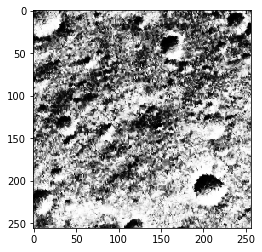

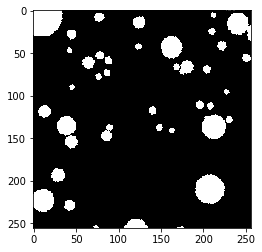

In [100]:
num = 9
plt.imshow(X[num, :, :, 0], cmap='Greys_r');
plt.show();
plt.imshow(yx[0][num, :, :, 0], cmap='Greys_r');
plt.show();

In [4]:
"""

model.compile(
    loss=['binary_crossentropy', 'mse'],
    loss_weights=[.999, .001],
    optimizer='adam',
    metrics=['acc']
)

tg = train_batch_gen(batch_size=20)
vg = val_batch_gen(batch_size=12)
history = model.fit_generator(
    tg,
    steps_per_epoch = 180,
    epochs = 25,
    validation_data = vg,
    validation_steps = 3
)
"""

"\n\nmodel.compile(\n    loss=['binary_crossentropy', 'mse'],\n    loss_weights=[.999, .001],\n    optimizer='adam',\n    metrics=['acc']\n)\n\ntg = train_batch_gen(batch_size=20)\nvg = val_batch_gen(batch_size=12)\nhistory = model.fit_generator(\n    tg,\n    steps_per_epoch = 180,\n    epochs = 25,\n    validation_data = vg,\n    validation_steps = 3\n)\n"

In [7]:
model = load_model('wvnet_model_2.h5')

In [8]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 256, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 16) 2320        batch_normalization_1[0][0]      
__________________________________________________________________________________________________
batch_norm

In [46]:
model.layers[-31].get_weights()[0].shape

(8, 8, 256, 16)

In [47]:
def wvnet_to_encodernet(model, anc=16):
    """Takes a wvnet and transfers its weights to a new
    model to produce crater pose encodings."""
    im_dim = (256, 256)
    encoding_length = 16

    inputs = Input(shape=(im_dim[0], im_dim[1], 1))
    conv3x3_1 = Conv2D(
        kernel_size=(3,3), 
        filters=anc*1, 
        padding='same', 
        activation='relu',
        weights = model.layers[1].get_weights()
    )(inputs)
    batchnorm1 = BatchNormalization(
        weights = model.layers[2].get_weights()
    )(conv3x3_1)
    conv3x3_2 = Conv2D(
        kernel_size=(3,3), 
        filters=anc*1, 
        padding='same', 
        activation='relu',
        weights = model.layers[3].get_weights()
    )(batchnorm1)
    batchnorm2 = BatchNormalization(
        weights = model.layers[4].get_weights()
    )(conv3x3_2)

    maxp1 = MaxPooling2D((2,2))(batchnorm2)
    sepconv1 = SeparableConv2D(
        kernel_size=(3,3), 
        filters=anc*2, 
        padding='same', 
        activation='relu',
        weights = model.layers[6].get_weights()
    )(maxp1)
    sepconv2 = SeparableConv2D(
        kernel_size=(3,3), 
        filters=anc*2, 
        padding='same', 
        activation='relu',
        weights = model.layers[7].get_weights()
    )(sepconv1)

    maxp2 = MaxPooling2D((2,2))(sepconv2)
    sepconv3 = SeparableConv2D(
        kernel_size=(3,3), 
        filters=anc*4, 
        padding='same', 
        activation='relu',
        weights = model.layers[9].get_weights()
    )(maxp2)
    sepconv4 = SeparableConv2D(
        kernel_size=(3,3), 
        filters=anc*4, 
        padding='same', 
        activation='relu',
        weights = model.layers[10].get_weights()
    )(sepconv3)

    maxp3 = MaxPooling2D((2,2))(sepconv4)
    sepconv5 = SeparableConv2D(
        kernel_size=(3,3), 
        filters=anc*8, 
        padding='same', 
        activation='relu',
        weights = model.layers[12].get_weights()
    )(maxp3)
    sepconv6 = SeparableConv2D(
        kernel_size=(3,3), 
        filters=anc*8, 
        padding='same', 
        activation='relu',
        weights = model.layers[13].get_weights()
    )(sepconv5)

    maxp4 = MaxPooling2D((2,2))(sepconv6)
    sepconv7 = SeparableConv2D(
        kernel_size=(3,3), 
        filters=anc*16, 
        padding='same', 
        activation='relu',
        weights = model.layers[15].get_weights()
    )(maxp4)
    sepconv8 = SeparableConv2D(
        kernel_size=(3,3), 
        filters=anc*16, 
        padding='same', 
        activation='relu',
        weights = model.layers[16].get_weights()
    )(sepconv7)

    #take down tensor for encoding.
    maxp_out1 = MaxPooling2D((2,2))(sepconv8)

    #this layer does the encoding
    encoder_convolution = Conv2D(
        kernel_size=(8, 8), 
        filters=encoding_length, 
        activation='relu', 
        name='encoder_convolution',
        weights = model.layers[-31].get_weights()
    )(maxp_out1)
    #this is our encoding:
    flattened_encoding = Flatten()(encoder_convolution)
    
    model = Model(inputs = inputs, outputs = flattened_encoding)
    return model

encoder_net = wvnet_to_encodernet(model)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 256, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 16) 2320        batch_normalization_1[0][0]      
__________________________________________________________________________________________________
batch_norm

In [48]:
encoder_net.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 256, 256, 1)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 256, 256, 16)      160       
_________________________________________________________________
batch_normalization_9 (Batch (None, 256, 256, 16)      64        
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 256, 256, 16)      2320      
_________________________________________________________________
batch_normalization_10 (Batc (None, 256, 256, 16)      64        
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 128, 128, 16)      0         
_________________________________________________________________
separable_conv2d_26 (Separab (None, 128, 128, 32)      688       
__________

In [108]:
def wvnet_to_decodernet(model, anc=16):
    """Takes the wvnet and transfers the weights to a new model
    which produces synthetic crater data with an encoded
    pose vector and a crater map
    """
    im_dim = (256, 256)
    encoding_length = 16

    input_map = Input(shape=(im_dim[0], im_dim[1], 1))
    
    conv3x3_1b = Conv2D(
        kernel_size=(3,3), 
        filters=anc*1, 
        padding='same', 
        activation='relu',
        weights = model.layers[34].get_weights()
    )(input_map)
    batchnorm1b = BatchNormalization(
        weights = model.layers[35].get_weights()
    )(conv3x3_1b)
    conv3x3_2b = Conv2D(
        kernel_size=(3,3), 
        filters=anc*1, 
        padding='same', 
        activation='relu',
        weights = model.layers[36].get_weights()
    )(batchnorm1b)
    batchnorm2b = BatchNormalization(
        weights = model.layers[37].get_weights()
    )(conv3x3_2b)

    maxp1b = MaxPooling2D((2,2))(batchnorm2b)
    sepconv1b = SeparableConv2D(
        kernel_size=(3,3), 
        filters=anc*2, 
        padding='same', 
        activation='relu',
        weights = model.layers[39].get_weights()
    )(maxp1b)
    sepconv2b = SeparableConv2D(
        kernel_size=(3,3), 
        filters=anc*2, 
        padding='same', 
        activation='relu',
        weights = model.layers[40].get_weights()
    )(sepconv1b)

    maxp2b = MaxPooling2D((2,2))(sepconv2b)
    sepconv3b = SeparableConv2D(
        kernel_size=(3,3), 
        filters=anc*4, 
        padding='same', 
        activation='relu',
        weights = model.layers[42].get_weights()
    )(maxp2b)
    sepconv4b = SeparableConv2D(
        kernel_size=(3,3), 
        filters=anc*4, 
        padding='same', 
        activation='relu',
        weights = model.layers[43].get_weights()
    )(sepconv3b)

    maxp3b = MaxPooling2D((2,2))(sepconv4b)
    sepconv5b = SeparableConv2D(
        kernel_size=(3,3), 
        filters=anc*8, 
        padding='same', 
        activation='relu',
        weights = model.layers[45].get_weights()
    )(maxp3b)
    sepconv6b = SeparableConv2D(
        kernel_size=(3,3), 
        filters=anc*8, 
        padding='same', 
        activation='relu',
        weights = model.layers[46].get_weights()
    )(sepconv5b)

    maxp4b = MaxPooling2D((2,2))(sepconv6b)
    sepconv7b = SeparableConv2D(
        kernel_size=(3,3), 
        filters=anc*16, 
        padding='same', 
        activation='relu',
        weights = model.layers[51].get_weights()
    )(maxp4b)
    sepconv8b = SeparableConv2D(
        kernel_size=(3,3), 
        filters=anc*16, 
        padding='same', 
        activation='relu',
        weights = model.layers[53].get_weights()
    )(sepconv7b)

    #We recover the information taken at maxp_out1
    maxp_out2 = MaxPooling2D((2,2))(sepconv8b)

    #now reshape and transpose convolution to reconstruct input image
    input_encoding = Input(shape=(16,))
    reshaped = Reshape(target_shape=(1, 1, 16))(input_encoding)
    decoder_convolution1 = Conv2DTranspose(
        kernel_size=(8,8), 
        strides=1, 
        filters=anc*16,
        weights = model.layers[54].get_weights()
    )(reshaped)
    decoder_concat1 = Concatenate()([decoder_convolution1, maxp_out2])
    decoder_convolution1x1_1 = Conv2D(
        kernel_size=(1,1), 
        strides=1, 
        filters=anc*16, 
        activation='relu',
        weights = model.layers[57].get_weights()
    )(decoder_concat1)
    decoder_convolution2 = Conv2DTranspose(
        kernel_size=(2,2), 
        strides=2, 
        filters=anc*8,
        weights = model.layers[58].get_weights()
    )(decoder_convolution1x1_1)
    decoder_concat2 = Concatenate()([decoder_convolution2, sepconv8b])
    decoder_convolution1x1_2 = Conv2D(
        kernel_size=(1,1), 
        strides=1, 
        filters=anc*16, 
        activation='relu'#,
        weights = model.layers[60].get_weights()
    )(decoder_concat2)

    #and complete the w for reconstructed image
    up1b = Conv2DTranspose(
        kernel_size=(2,2), 
        strides=2, 
        filters=anc*8,
        weights = model.layers[61].get_weights()
    )(decoder_convolution1x1_2)
    concat1b = Concatenate()([sepconv6b, up1b])
    sepconv9b = SeparableConv2D(
        kernel_size=(3,3), 
        filters=anc*8, 
        padding='same', 
        activation='relu',
        weights = model.layers[63].get_weights()
    )(concat1b)
    sepconv10b = SeparableConv2D(
        kernel_size=(3,3), 
        filters=anc*8, 
        padding='same', 
        activation='relu',
        weights = model.layers[64].get_weights()
    )(sepconv9b)

    up2b = Conv2DTranspose(
        kernel_size=(2,2), 
        strides=2, 
        filters=anc*4,
        weights = model.layers[65].get_weights()
    )(sepconv10b)
    concat2b = Concatenate()([sepconv4b, up2b])
    sepconv11b = SeparableConv2D(
        kernel_size=(3,3), 
        filters=anc*4, 
        padding='same', 
        activation='relu',
        weights = model.layers[67].get_weights()
    )(concat2b)
    sepconv12b = SeparableConv2D(
        kernel_size=(3,3), 
        filters=anc*4, 
        padding='same', 
        activation='relu',
        weights = model.layers[68].get_weights()
    )(sepconv11b)

    up3b = Conv2DTranspose(
        kernel_size=(2,2), 
        strides=2, 
        filters=anc*2,
        weights = model.layers[69].get_weights()
    )(sepconv12b)
    concat3b = Concatenate()([sepconv2b, up3b])
    sepconv13b = SeparableConv2D(
        kernel_size=(3,3), 
        filters=anc*2, 
        padding='same', 
        activation='relu',
        weights = model.layers[71].get_weights()
    )(concat3b)
    sepconv14b = SeparableConv2D(
        kernel_size=(3,3), 
        filters=anc*2, 
        padding='same', 
        activation='relu',
        weights = model.layers[72].get_weights()
    )(sepconv13b)

    up4b = Conv2DTranspose(
        kernel_size=(2,2), 
        strides=2, 
        filters=anc*1,
        weights = model.layers[73].get_weights()
    )(sepconv14b)
    concat4b = Concatenate()([batchnorm2b, up4b])
    sepconv15b = SeparableConv2D(
        kernel_size=(3,3), 
        filters=anc*1, 
        padding='same', 
        activation='relu',
        weights = model.layers[75].get_weights()
    )(concat4b)
    sepconv16b = SeparableConv2D(
        kernel_size=(3,3), 
        filters=anc*1, 
        padding='same', 
        activation='relu',
        weights = model.layers[76].get_weights()
    )(sepconv15b)

    reconstructed_image = Conv2D(
        kernel_size=(1,1), 
        filters=1, 
        name='reconstruction',
        weights = model.layers[78].get_weights()
    )(sepconv16b)
    
    model = Model(inputs=[input_map, input_encoding], outputs=reconstructed_image)
    return model

decoder_model = wvnet_to_decodernet(model)
decoder_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_28 (Conv2D)              (None, 256, 256, 16) 160         input_17[0][0]                   
__________________________________________________________________________________________________
batch_normalization_23 (BatchNo (None, 256, 256, 16) 64          conv2d_28[0][0]                  
__________________________________________________________________________________________________
conv2d_29 (Conv2D)              (None, 256, 256, 16) 2320        batch_normalization_23[0][0]     
__________________________________________________________________________________________________
batch_norm

In [172]:
def wvnet_to_unet(model, anc=16):
    """Takes a wvnet and transfers its weights to a new
    model to produce a crater detection U-net"""
    im_dim = (256, 256)
    encoding_length = 16

    inputs = Input(shape=(im_dim[0], im_dim[1], 1))
    conv3x3_1 = Conv2D(
        kernel_size=(3,3), 
        filters=anc*1, 
        padding='same', 
        activation='relu',
        weights = model.layers[1].get_weights()
    )(inputs)
    batchnorm1 = BatchNormalization(
        weights = model.layers[2].get_weights()
    )(conv3x3_1)
    conv3x3_2 = Conv2D(
        kernel_size=(3,3), 
        filters=anc*1, 
        padding='same', 
        activation='relu',
        weights = model.layers[3].get_weights()
    )(batchnorm1)
    batchnorm2 = BatchNormalization(
        weights = model.layers[4].get_weights()
    )(conv3x3_2)

    maxp1 = MaxPooling2D((2,2))(batchnorm2)
    sepconv1 = SeparableConv2D(
        kernel_size=(3,3), 
        filters=anc*2, 
        padding='same', 
        activation='relu',
        weights = model.layers[6].get_weights()
    )(maxp1)
    sepconv2 = SeparableConv2D(
        kernel_size=(3,3), 
        filters=anc*2, 
        padding='same', 
        activation='relu',
        weights = model.layers[7].get_weights()
    )(sepconv1)

    maxp2 = MaxPooling2D((2,2))(sepconv2)
    sepconv3 = SeparableConv2D(
        kernel_size=(3,3), 
        filters=anc*4, 
        padding='same', 
        activation='relu',
        weights = model.layers[9].get_weights()
    )(maxp2)
    sepconv4 = SeparableConv2D(
        kernel_size=(3,3), 
        filters=anc*4, 
        padding='same', 
        activation='relu',
        weights = model.layers[10].get_weights()
    )(sepconv3)

    maxp3 = MaxPooling2D((2,2))(sepconv4)
    sepconv5 = SeparableConv2D(
        kernel_size=(3,3), 
        filters=anc*8, 
        padding='same', 
        activation='relu',
        weights = model.layers[12].get_weights()
    )(maxp3)
    sepconv6 = SeparableConv2D(
        kernel_size=(3,3), 
        filters=anc*8, 
        padding='same', 
        activation='relu',
        weights = model.layers[13].get_weights()
    )(sepconv5)

    maxp4 = MaxPooling2D((2,2))(sepconv6)
    sepconv7 = SeparableConv2D(
        kernel_size=(3,3), 
        filters=anc*16, 
        padding='same', 
        activation='relu',
        weights = model.layers[15].get_weights()
    )(maxp4)
    sepconv8 = SeparableConv2D(
        kernel_size=(3,3), 
        filters=anc*16, 
        padding='same', 
        activation='relu',
        weights = model.layers[16].get_weights()
    )(sepconv7)

    up1 = Conv2DTranspose(
        kernel_size=(2,2),
        strides=2,
        filters=anc*8,
        weights = model.layers[17].get_weights()
    )(sepconv8)
    concat1 = Concatenate()([sepconv6, up1])
    sepconv9 = SeparableConv2D(
        kernel_size=(3,3), 
        filters=anc*8, 
        padding='same', 
        activation='relu',
        weights = model.layers[19].get_weights()
    )(concat1)
    sepconv10 = SeparableConv2D(
        kernel_size=(3,3), 
        filters=anc*8, 
        padding='same', 
        activation='relu',
        weights = model.layers[20].get_weights()
    )(sepconv9)

    up2 = Conv2DTranspose(
        kernel_size=(2,2), 
        strides=2, 
        filters=anc*4,
        weights = model.layers[21].get_weights()
    )(sepconv10)
    concat2 = Concatenate()([sepconv4, up2])
    sepconv11 = SeparableConv2D(
        kernel_size=(3,3), 
        filters=anc*4, 
        padding='same', 
        activation='relu',
        weights = model.layers[23].get_weights()
    )(concat2)
    sepconv12 = SeparableConv2D(
        kernel_size=(3,3), 
        filters=anc*4, 
        padding='same', 
        activation='relu',
        weights = model.layers[24].get_weights()
    )(sepconv11)

    up3 = Conv2DTranspose(
        kernel_size=(2,2), 
        strides=2, 
        filters=anc*2,
        weights = model.layers[25].get_weights()
    )(sepconv12)
    concat3 = Concatenate()([sepconv2, up3])
    sepconv13 = SeparableConv2D(
        kernel_size=(3,3), 
        filters=anc*2, 
        padding='same', 
        activation='relu',
        weights = model.layers[27].get_weights()
    )(concat3)
    sepconv14 = SeparableConv2D(
        kernel_size=(3,3), 
        filters=anc*2, 
        padding='same', 
        activation='relu',
        weights = model.layers[28].get_weights()
    )(sepconv13)

    up4 = Conv2DTranspose(
        kernel_size=(2,2), 
        strides=2, 
        filters=anc*1,
        weights = model.layers[29].get_weights()
    )(sepconv14)
    concat4 = Concatenate()([batchnorm2, up4])
    sepconv15 = SeparableConv2D(
        kernel_size=(3,3), 
        filters=anc*1, 
        padding='same', 
        activation='relu',
        weights = model.layers[31].get_weights()
    )(concat4)
    sepconv16 = SeparableConv2D(
        kernel_size=(3,3), 
        filters=anc*1, 
        padding='same', 
        activation='relu',
        weights = model.layers[32].get_weights()
    )(sepconv15)

    pixel_map = Conv2D(
        kernel_size=(1,1), 
        filters=1, 
        activation='sigmoid', 
        name='pixel_map',
        weights = model.layers[33].get_weights()
    )(sepconv16)
    
    model = Model(inputs = inputs, outputs = pixel_map)
    return model

unet_model = wvnet_to_unet(model)
unet_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_38 (Conv2D)              (None, 256, 256, 16) 160         input_22[0][0]                   
__________________________________________________________________________________________________
batch_normalization_31 (BatchNo (None, 256, 256, 16) 64          conv2d_38[0][0]                  
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 256, 256, 16) 2320        batch_normalization_31[0][0]     
__________________________________________________________________________________________________
batch_norm

In [176]:
vg = val_batch_gen(batch_size=4)
for i in range(6):
    X, yx = next(vg)

In [178]:
predictions = unet_model.predict(X)

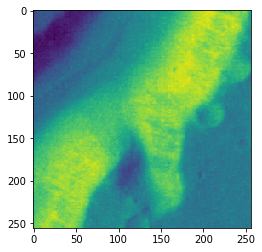

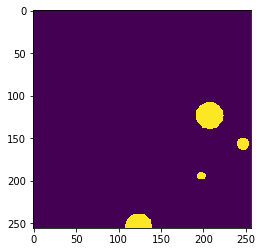

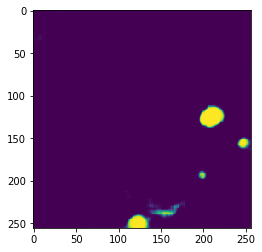

In [183]:
la = 1
plt.imshow(X[la, :, :, 0])
plt.show()
plt.imshow(yx[0][la, :, :, 0])
plt.show()
plt.imshow(predictions[la, :, :, 0])
plt.show()

In [197]:
encodings = encoder_net.predict(X)
encoding = encodings[la, :]

In [194]:
reconstruction_target = decoder_model.predict([yx[0], encodings])
reconstruction_predictions = decoder_model.predict([predictions, encodings])
plt.imshow(reconstruction_target[la, :, :, 0])
plt.show();
plt.imshow(reconstruction_predictions[la, :, :, 0])
plt.show();

In [204]:
def try_encoding(encoding):
    reconstruction_target = decoder_model.predict([np.array([yx[0][la, :, :, :]]), np.array([encoding])])
    reconstruction_predictions = decoder_model.predict([np.array([predictions[la, :, :, :]]), np.array([encoding])])
    plt.imshow(reconstruction_target[0, :, :, 0])
    plt.show();
    plt.imshow(reconstruction_predictions[0, :, :, 0])
    plt.show();
    return

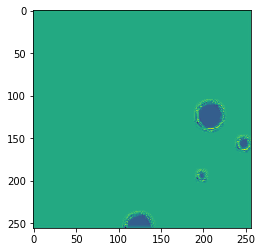

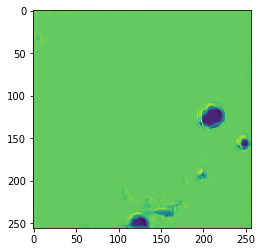

In [215]:
try_encoding(np.random.random(16))

In [211]:
np.random.random((16))

array([0.22063659, 0.8231175 , 0.74708939, 0.15516562, 0.13180459,
       0.96227118, 0.11783213, 0.18369808, 0.75864717, 0.68528267,
       0.74538615, 0.24589615, 0.79975662, 0.30575015, 0.60387559,
       0.72083679])